In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, time, json
import pandas as pd
from openai import OpenAI
from tqdm.auto import tqdm
import spacy

import sys
sys.path.append("../")
import os

import logging
from src.utils import logging_utils
from src.utils import env_utils
from src import functional

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}")
logger.info(f"{transformers.__version__=}")

/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2024-09-05 15:31:44 __main__ INFO     torch.__version__='2.3.1', torch.version.cuda='12.1'
2024-09-05 15:31:44 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=1, torch.cuda.get_device_name()='NVIDIA RTX A6000'
2024-09-05 15:31:44 __main__ INFO     transformers.__version__='4.44.2'


In [3]:
def get_location(key: str):
    return key.split("_<>_")

def get_average_indirect_effects(indirect_effects: list[dict], query_start: list[int] = None):
    """Will average the contributions of heads across all examples and different token positions"""
    if query_start is None:
        query_start = [0] * len(indirect_effects)
    else:
        assert len(query_start) == len(indirect_effects)

    modules = list(set([get_location(key)[0] for key in indirect_effects[0].keys()]))
    aie = {key: 0 for key in modules}
    for ie, st in zip(indirect_effects, query_start):
        for key in ie.keys():
            module_name, token_idx = get_location(key)
            # print(f"{module_name=}, {token_idx=} | {st=}")
            if int(token_idx) < st:
                print(f"{token_idx=} < {st=} .. skipping") # seems like I am just saving after the query start
                continue
            assert module_name in modules
            aie[module_name] += ie[key]
    for key in aie.keys():
        aie[key] /= len(indirect_effects)
    return aie

def get_head_matrix_for_plotting(aie):
    layer_name_format = "model.layers.{}"
    attn_head_name_format = ".self_attn.{}"

    head_aie_matrix = torch.zeros((32, 32))
    for l in range(32):
        layer = layer_name_format.format(l)
        for h in range(32):
            attn_head = layer + attn_head_name_format.format(h)
            head_aie_matrix[l, h] = aie[attn_head]
    return head_aie_matrix

# aie = get_average_indirect_effects(
#     [d["indirect_effects"] for d in dct["attribution_patching_results"]]
# )

In [4]:
import numpy as np

model_key = "meta-llama/Meta-Llama-3-8B-Instruct"
results_dir = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "attribution_patching",
    model_key.split("/")[-1],
)

relations = os.listdir(results_dir)

dct_relations = {}
for relation in relations:
    with open(os.path.join(results_dir, f"{relation}/{relation}.json")) as f:
        dct_relations[relation] = json.load(f)

# print(dct.keys())
# dct["attribution_patching_results"][0].keys()

In [5]:
relation = "sport_players"
dct = dct_relations[relation]

In [6]:
dct["attribution_patching_results"][0]["query_start"]

44

2024-09-05 15:31:45 matplotlib DEBUG    matplotlib data path: /home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data
2024-09-05 15:31:45 matplotlib DEBUG    CONFIGDIR=/home/local_arnab/.config/matplotlib
2024-09-05 15:31:45 matplotlib DEBUG    interactive is False
2024-09-05 15:31:45 matplotlib DEBUG    platform is linux
2024-09-05 15:31:45 matplotlib DEBUG    CACHEDIR=/home/local_arnab/.cache/matplotlib
2024-09-05 15:31:45 matplotlib.font_manager DEBUG    Using fontManager instance from /home/local_arnab/.cache/matplotlib/fontlist-v330.json
2024-09-05 15:31:52 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-09-05 15:31:52 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-09-05 15:31:52 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-09-05 15:31:52 

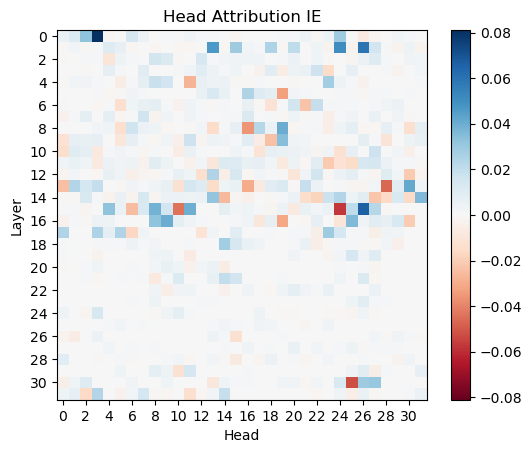

In [7]:
from src.plotting import matrix_heatmap

indirect_effects = []
query_start_indices = []
for relation in relations:
    dct = dct_relations[relation]
    indirect_effects.extend([d["indirect_effects"] for d in dct["attribution_patching_results"]])
    query_start_indices.extend([d["query_start"] for d in dct["attribution_patching_results"]])

aie = get_average_indirect_effects(
    # [d["indirect_effects"] for d in dct["attribution_patching_results"]]
    indirect_effects,
    query_start = query_start_indices
)
head_aie_matrix = get_head_matrix_for_plotting(aie)

matrix_heatmap(
    matrix = head_aie_matrix,
    x_label="Head",
    y_label="Layer",
    tick_gap=2,
    title="Head Attribution IE",
)

2024-09-05 15:31:56 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f9ff1416a10>


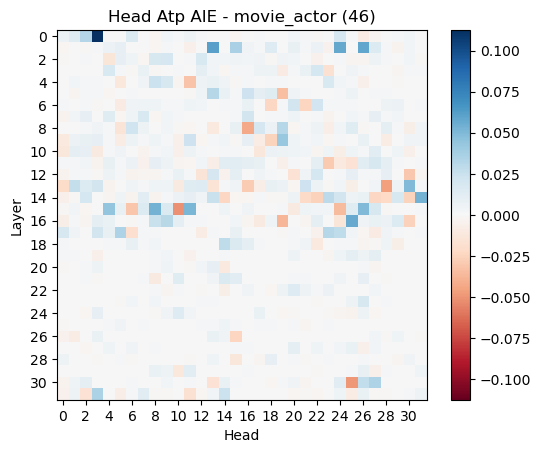

2024-09-05 15:31:57 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f9ff14e9a90>


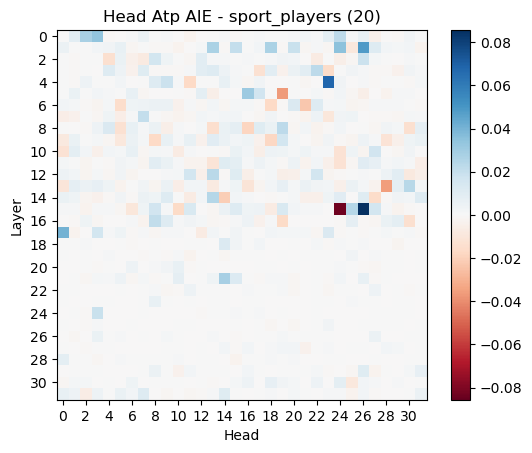

2024-09-05 15:31:58 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f9ff14366d0>


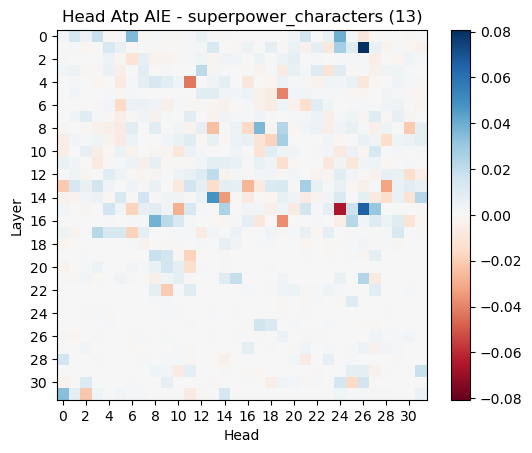

2024-09-05 15:31:59 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f9ff1287b50>


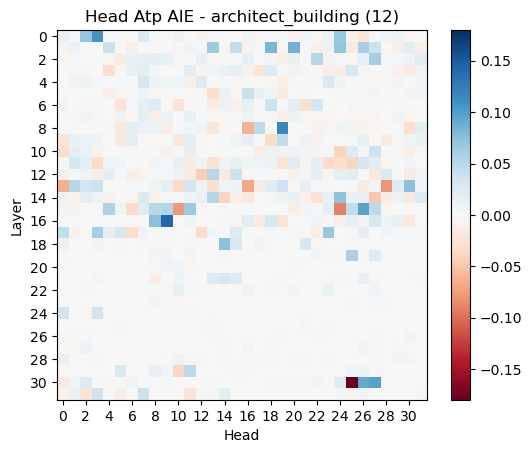

In [8]:
for relation in relations:
    dct = dct_relations[relation]
    aie = get_average_indirect_effects(
        [d["indirect_effects"] for d in dct["attribution_patching_results"]]
    )
    head_aie_matrix = get_head_matrix_for_plotting(aie)

    matrix_heatmap(
        matrix = head_aie_matrix,
        x_label="Head",
        y_label="Layer",
        tick_gap=2,
        title=f"Head Atp AIE - {relation} ({len(dct['attribution_patching_results'])})",
    )

In [9]:
N_LAYER = 32
def process_indirect_effect(atp_result, layer_name_format):
    query_start = atp_result["query_start"]
    clean_toks = atp_result["clean_toks"][query_start:]
    patch_toks = atp_result["patch_toks"][query_start:]

    subj_1_range = atp_result["subj_1_range"]
    subj_1_range_wo_last = subj_1_range[0] - query_start, subj_1_range[1] - query_start - 1
    subj_1_last = subj_1_range[1] - query_start - 1

    subj_2_range = atp_result["subj_2_range"]
    subj_2_range_wo_last = subj_2_range[0] - query_start, subj_2_range[1] - query_start - 1
    subj_2_last = subj_2_range[1] - query_start - 1

    p_patch_ans = atp_result["patch_ans"]["prob"]
    p_patch_ans_corrupt = atp_result["corrupt_patch_ans"][1]["prob"]

    indirect_effects = torch.zeros((len(clean_toks), N_LAYER))

    for layer in range(N_LAYER):
        layer_name = layer_name_format.format(layer)
        for token_pos in range(len(clean_toks)):
            key = f"{layer_name}_<>_{query_start + token_pos}"
            indirect_effects[token_pos, layer] = atp_result["indirect_effects"][key]

    indirect_effects = (indirect_effects - p_patch_ans_corrupt)/(p_patch_ans - p_patch_ans_corrupt)
    indirect_effects.shape

    tok_ies = {}
    for i, tok in enumerate(clean_toks):
        if i in range(subj_1_range_wo_last[0], subj_1_range_wo_last[1]):
            if i == subj_1_range_wo_last[0]:
                tok_ies["subj1[0 : -1]"] = indirect_effects[i : subj_1_range_wo_last[1]].mean(dim=0)
            else:
                continue
        elif i == subj_1_last:
            tok_ies["subj1_last*"] = indirect_effects[i]
        elif i in range(subj_2_range_wo_last[0], subj_2_range_wo_last[1]):
            if i == subj_2_range_wo_last[0]:
                tok_ies["subj2[0 : -1]*"] = indirect_effects[i : subj_2_range_wo_last[1]].mean(dim=0)
            else:
                continue
        elif i == subj_2_last:
            tok_ies["subj2_last"] = indirect_effects[i]
        else:
            tok_ies[tok] = indirect_effects[i]
    return tok_ies

In [10]:
format_to_type = {
    "model.layers.{}" : "residual",
    "model.layers.{}.self_attn" : "attention",
    "model.layers.{}.mlp": "mlp",     
}

relation_name='architect_building', len(atp_results)=12
2024-09-05 15:32:29 matplotlib.font_manager DEBUG    findfont: Matching Times New Roman:style=normal:variant=normal:weight=normal:stretch=normal:size=6.0.
2024-09-05 15:32:29 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-09-05 15:32:29 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-09-05 15:32:29 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packa

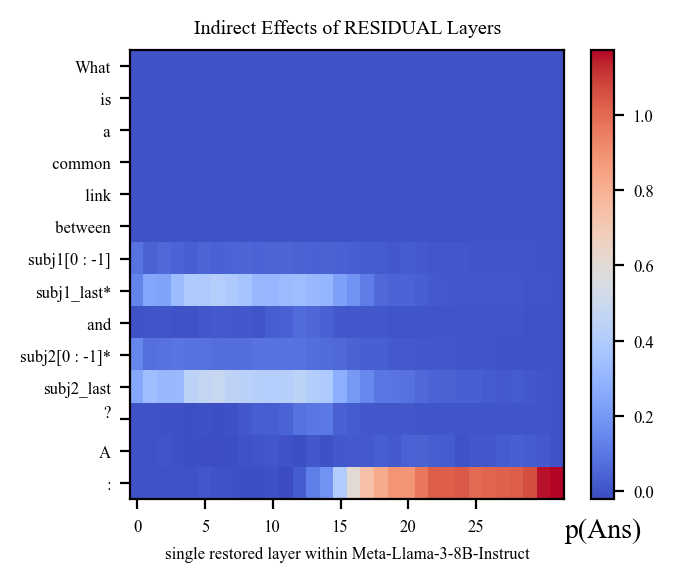

2024-09-05 15:32:30 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f9ff0bb7590>
2024-09-05 15:32:30 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-09-05 15:32:30 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-09-05 15:32:30 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-09-05 15:32:30 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


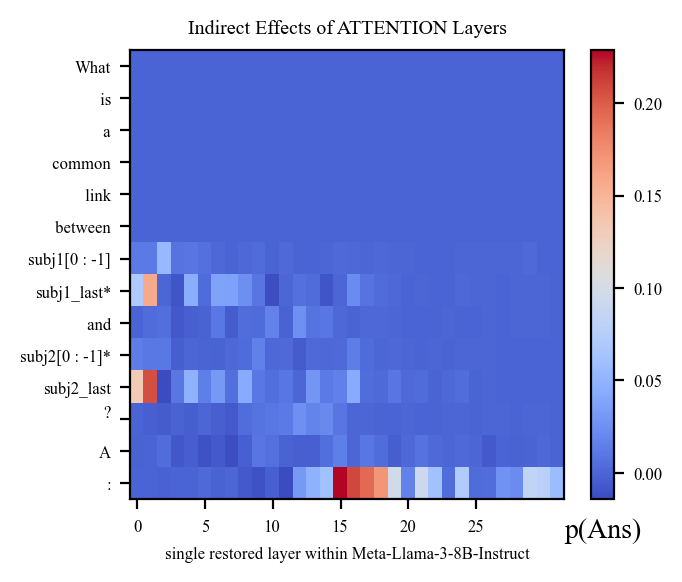

2024-09-05 15:32:30 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f9ff0b8c290>
2024-09-05 15:32:30 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-09-05 15:32:30 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-09-05 15:32:30 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-09-05 15:32:30 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


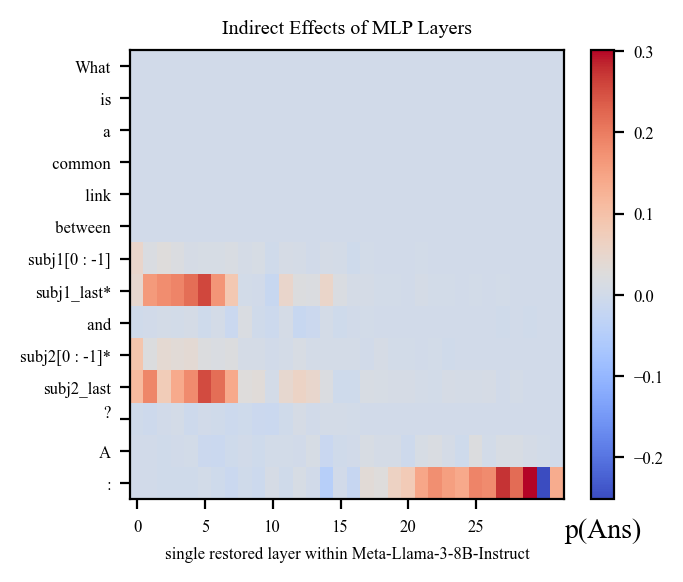

In [12]:
from src.trace import CausalTracingResult
from src.utils.typing import PredictedToken
from src.plotting import plot_trace_heatmap

relation_name = "architect_building"

dct = dct_relations[relation_name]
atp_results = dct["attribution_patching_results"]
# layer_name_format = "model.layers.{}"
# layer_name_format = "model.layers.{}.self_attn"
layer_name_format = "model.layers.{}.mlp"

print(f"{relation_name=}, {len(atp_results)=}")

for layer_name_format in format_to_type.keys():
    tok_aies = {}
    for atp_result in atp_results:
        cur_tok_ies = process_indirect_effect(atp_result, layer_name_format)
        for tok, ie in cur_tok_ies.items():
            if tok not in tok_aies:
                tok_aies[tok] = torch.zeros(N_LAYER)
            tok_aies[tok] += ie

    for tok, ie in tok_aies.items():
        tok_aies[tok] = ie/len(atp_results)        

    indirect_effects = torch.stack(list(tok_aies.values()))
    trace_result = CausalTracingResult(
        corrupt_input_toks= list(tok_aies.keys()),
        patch_input_toks= list(tok_aies.keys()),
        trace_start_idx=0,
        answer = PredictedToken(token="Ans", prob=-1, token_id=-1),
        low_score=indirect_effects.min().item(),
        window = 1,
        normalized=True,
        kind = format_to_type[layer_name_format],
        indirect_effects=indirect_effects,
    )

    plot_trace_heatmap(
        result = trace_result,
        model_name = model_key.split("/")[-1],
        # savepdf=os.path.join(save_dir, f"{kind}.pdf")
        color_map="coolwarm",
    )

In [25]:
from scripts.causal_tracing import CacheCausalTracingResult, ExperimentResults
from src.trace import CausalTracingResult
from src.plotting import plot_trace_heatmap
from typing import Literal

relation_name : Literal[
    "architect_building",
    "movie_actor",
    "sport_players",
    "superpower_characters",
    "all",
] = "superpower_characters"

cache_patch = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "causal_tracing",
    model_key.split("/")[-1],
    relation_name,
)

with open(os.path.join(cache_patch, f"{relation_name}.json"), "r") as f:
    cache_data = json.load(f)
# exp_results = ExperimentResults.from_dict(cache_data)
exp_results = cache_data

print(f'{relation_name=}, num_samples={len(exp_results["causal_tracing_results"])}')

relation_name='superpower_characters', num_samples=13


2024-09-05 15:41:58 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f9ff11517d0>
2024-09-05 15:41:58 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-09-05 15:41:58 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-09-05 15:41:58 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-09-05 15:41:58 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


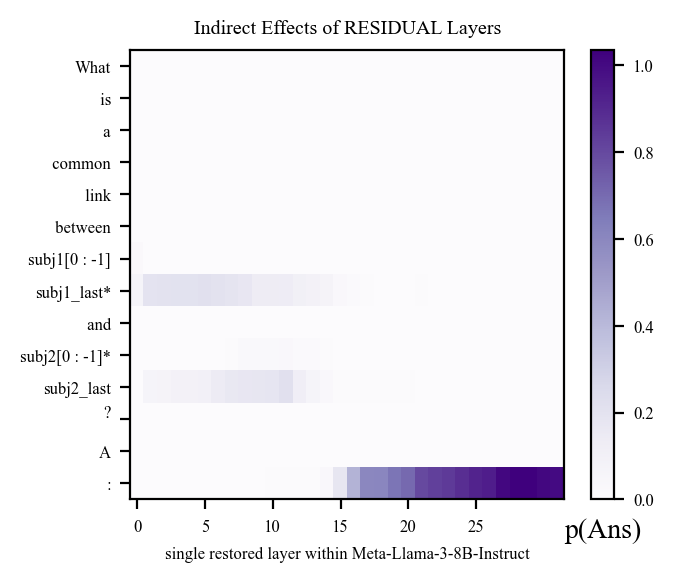

2024-09-05 15:41:59 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f9ff01f6d10>
2024-09-05 15:41:59 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-09-05 15:41:59 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-09-05 15:41:59 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-09-05 15:41:59 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


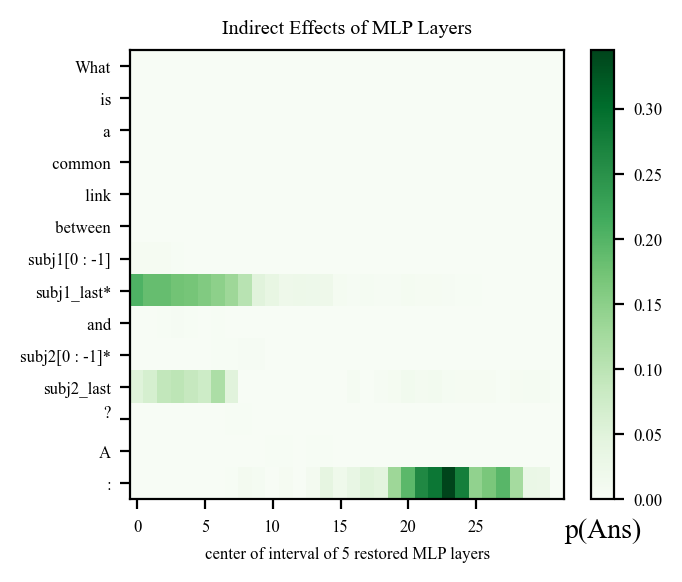

2024-09-05 15:41:59 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7f9ff136c090>
2024-09-05 15:41:59 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-09-05 15:41:59 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-09-05 15:41:59 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2024-09-05 15:41:59 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


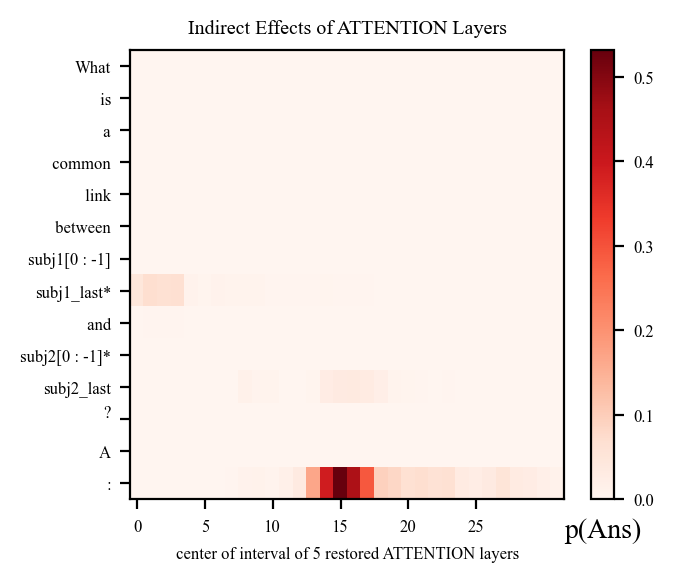

In [27]:
kind_to_module_name_format = {
    "residual": "model.layers.{}",
    "mlp": "model.layers.{}.mlp",
    "attention": "model.layers.{}.self_attn",
}

for kind in kind_to_module_name_format:
    layer_name_format = kind_to_module_name_format[kind]
    tok_aies = {}

    for ct_result in exp_results["causal_tracing_results"]:
        cur_tok_ies = process_indirect_effect(ct_result, layer_name_format)
        for tok, ie in cur_tok_ies.items():
            if tok not in tok_aies:
                tok_aies[tok] = torch.zeros(N_LAYER)
            tok_aies[tok] += ie
    
    for tok, ie in tok_aies.items():
        tok_aies[tok] = ie/len(exp_results["causal_tracing_results"])
    
    indirect_effects_matrix = torch.stack(list(tok_aies.values()))

    trace_result = CausalTracingResult(
        corrupt_input_toks=list(tok_aies.keys()),
        patch_input_toks=list(tok_aies.keys()),
        indirect_effects=indirect_effects_matrix,
        answer=PredictedToken(token="Ans", prob=-1, token_id=-1),
        window=exp_results["window_size"][kind],
        normalized=True,
        kind=kind,
        trace_start_idx=0,
        low_score=0.0,
    )

    plot_trace_heatmap(
        result = trace_result,
        model_name = model_key.split("/")[-1],
        # savepdf=os.path.join(save_dir, f"{kind}.pdf")
    )
